In [14]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [107]:
# Import learning modules
import statsmodels.api as sm

from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb
from xgboost import XGBRegressor

In [33]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.5)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [94]:
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [73]:
def pred_plot(y_pred, y_true, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(y_pred, y_true, color='b', label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('predicted')
    ax.set_ylabel('actual')
    ax.legend()

    plt.show()

In [35]:
# Read file
df = pd.read_csv('Data/Written_essay_scores_cleaned.csv')

In [36]:
df['Grade/Degree'].fillna('N/A')
df['Grade/Degree'] = df['Grade/Degree'].astype(str)
df['Acad. Genre'] = df['Acad. Genre'].fillna('N/A')
df['Major/ Occupation'] = df['Major/ Occupation'].fillna('N/A')
df = df.drop(['Total 2 (Weighted %)', 'Unnamed: 0', 'INTM+INSM', 'INTM-INSM', 'Major/ Occupation', 'Code', 
              'Content (/12)', 'Organization (/12)', 'Vocabulary (/12)', 'Language Use (/12)', 'Mechanics (/12)'], axis=1)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total 1 (%)    321 non-null    float64
 1   Country        321 non-null    object 
 2   PTJ1 (wds)     321 non-null    int64  
 3   SMK1 (wds)     321 non-null    int64  
 4   Sex            321 non-null    object 
 5   Age            321 non-null    int64  
 6   Grade/Degree   321 non-null    object 
 7   Acad. Genre    321 non-null    object 
 8   VST            321 non-null    float64
 9   CEFR           321 non-null    object 
 10  INTM           321 non-null    float64
 11  INSM           321 non-null    float64
 12  Primary        321 non-null    float64
 13  Secondary      321 non-null    float64
 14  College        321 non-null    float64
 15  Inschool       321 non-null    float64
 16  Outschool      321 non-null    float64
 17  Listening      321 non-null    float64
 18  Reading   

In [79]:
X = df.drop(['Total 1 (%)'], axis=1).copy()
X = pd.get_dummies(X)

y = df['Total 1 (%)'].copy()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
lr_pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())
params = {'selectkbest__k': [k+1 for k in range(len(X_train.columns))]}
lr_grid_cv = GridSearchCV(lr_pipe, param_grid = params, cv=5, n_jobs=-1)

In [85]:
lr_grid_cv.fit(X_train, y_train)
print(lr_grid_cv.best_params_)
lr_best = lr_grid_cv.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001729CD15430>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [88]:
lr_best.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001729CD15430>)),
                ('linearregression', LinearRegression())])

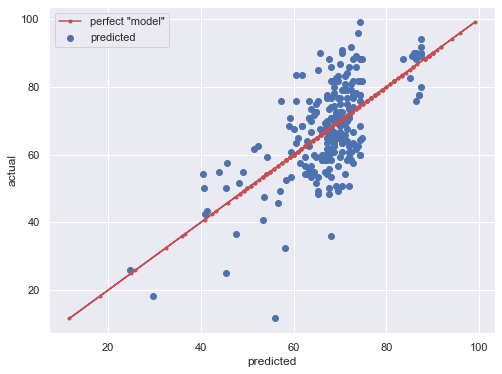

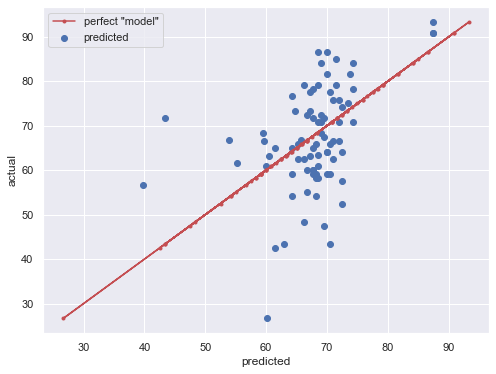

In [102]:
y_tr_lr_pred = lr_best.predict(X_train)
y_te_lr_pred = lr_best.predict(X_test)
pred_plot(y_tr_lr_pred, y_train)
pred_plot(y_te_lr_pred, y_test)

In [95]:
test_stat("Linear Regression", y_test, y_te_lr_pred)

Linear Regression : 
R^2:  0.16004518014139768
RMSE:  10.826944182881997


In [96]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
grid_params = {
    'randomforestregressor__n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'randomforestregressor__max_depth': [10, 20, 30, None],
    'standardscaler': [StandardScaler(), None]
}
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [97]:
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
rf_best = rf_grid_cv.best_estimator_

{'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 1000, 'standardscaler': None}


In [98]:
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,3.529355,0.094509,0.112299,0.006070,20,1000,None,"{'randomforestregressor__max_depth': 20, 'rand...",0.075880,0.316858,0.497360,0.339758,0.392599,0.324491,0.139012,1
39,3.176901,0.491543,0.080587,0.036339,None,1000,None,"{'randomforestregressor__max_depth': None, 'ra...",0.074827,0.325682,0.503817,0.331390,0.386524,0.324448,0.140276,2
8,3.231751,0.052478,0.109307,0.001018,10,1000,StandardScaler(),"{'randomforestregressor__max_depth': 10, 'rand...",0.067753,0.320242,0.496397,0.343914,0.392682,0.324197,0.141782,3
38,3.636867,0.056098,0.122871,0.009301,None,1000,StandardScaler(),"{'randomforestregressor__max_depth': None, 'ra...",0.082669,0.322927,0.503838,0.322611,0.388096,0.324028,0.137618,4
37,1.162489,0.014461,0.039295,0.002863,None,316,None,"{'randomforestregressor__max_depth': None, 'ra...",0.051474,0.339426,0.515317,0.328373,0.383954,0.323709,0.151475,5


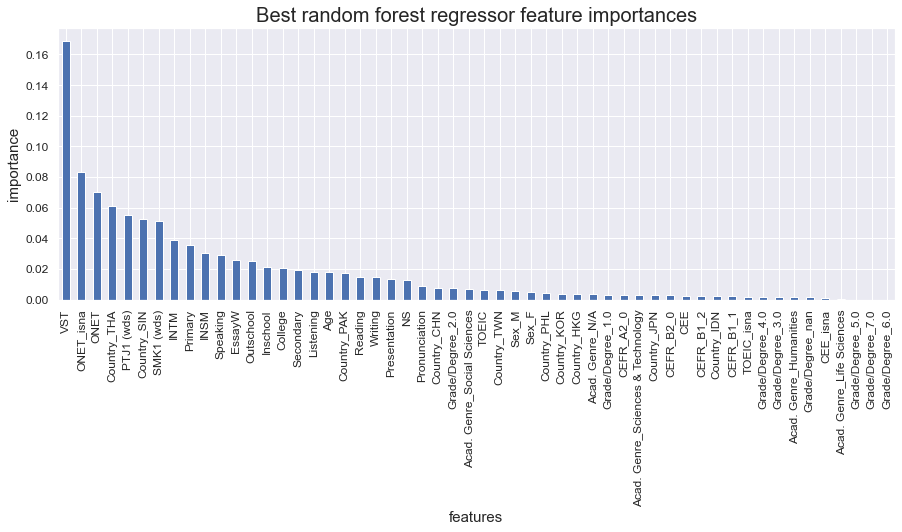

In [99]:
rf_best.fit(X_train, y_train)

plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar', fontsize=12)
plt.xlabel('features', fontsize=15)
plt.ylabel('importance', fontsize=15)
plt.title('Best random forest regressor feature importances', fontsize=20);

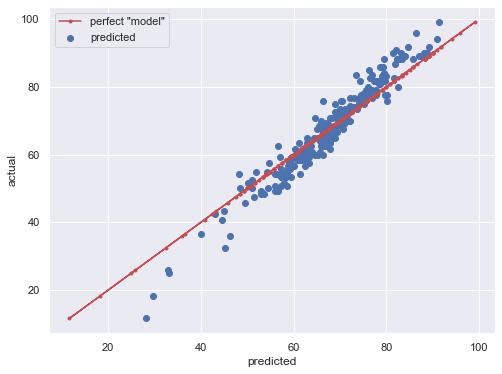

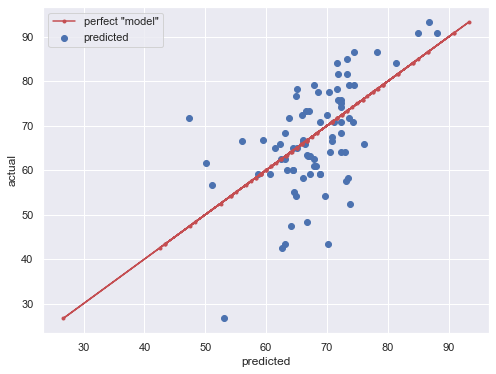

In [103]:
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)
pred_plot(y_tr_rf_pred, y_train)
pred_plot(y_te_rf_pred, y_test)

In [104]:
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.3151789632407851
RMSE:  9.776119035549298


In [105]:
DM_train = xgb.DMatrix(X_train, y_train)
DM_test = xgb.DMatrix(X_test, y_test)

In [119]:
xg = XGBRegressor(objective='reg:linear', seed=42)
params = {
    'max_depth': range(2, 8, 1),
    'n_estimators': range(60, 300, 40),
    'learning_rate': [1, 0.1, 0.01]
}
xg_grid_cv = GridSearchCV(xg, param_grid=params, cv=5, n_jobs=-1)

In [120]:
xg_grid_cv.fit(X_train, y_train)

[14:06:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
              

In [121]:
xg_grid_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}

In [124]:
params = {
    'max_depth': range(1, 4),
    'n_estimators': range(10, 60, 10),
    'learning_rate': [0.1]
}
xg_grid_cv = GridSearchCV(xg, param_grid=params, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)

[14:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
              

In [125]:
xg_grid_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 40}

In [126]:
xg_best = xg_grid_cv.best_estimator_

In [129]:
xg_best.fit(X_train, y_train)

[14:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

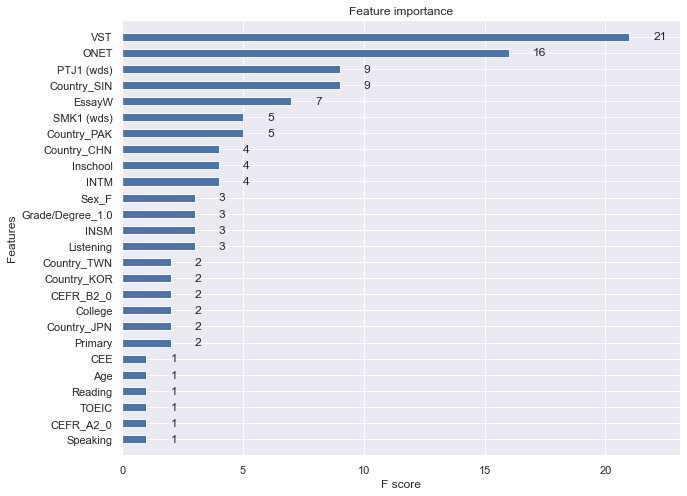

In [140]:
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, ax=ax, height=0.5)
plt.show()

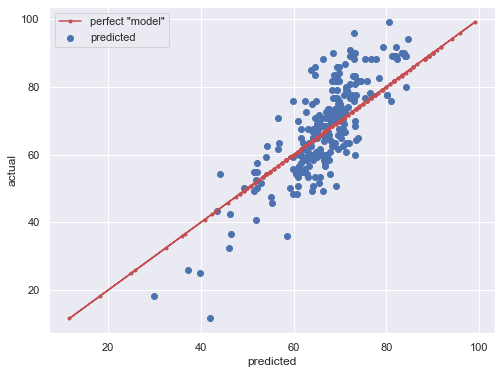

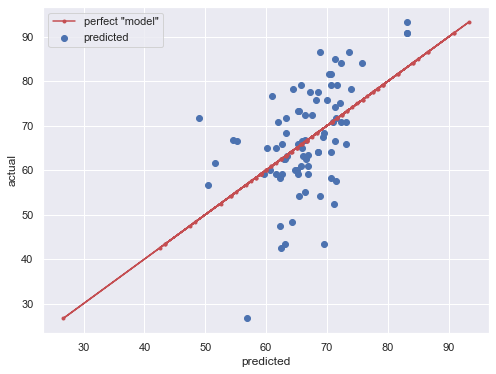

In [132]:
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)
pred_plot(y_tr_xg_pred, y_train)
pred_plot(y_te_xg_pred, y_test)

In [133]:
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.2721354372601317
RMSE:  10.07866992494456
